In [1]:
import h5py
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from tqdm import tqdm, tqdm_notebook
import tensorflow as tf

## Bilateral Inception

### Модель

In [3]:
class BilateralFilter():
    
    def __init__(self):
        # Trainable variables: transformation matrix Lambda and scale parameter theta
        self.Lambda = tf.Variable(np.eye(3), dtype=tf.float64, trainable=True)
        self.theta = tf.Variable([1], dtype=tf.float64, trainable=True)
        
        
    def __call__(self, z, features):
        """
        Applies bilateral filter to 
        Input:
        z: superpixels of predicted image - 3d tensor (batch_size, 1024, 1)
        features: coordinates and depth of pixels of predicted image - 3d tensor (batch_size, 1024, 3)
        
        Output:
        z_new: superpixels of filtered image - 3d tensor (batch_size, 1024, 1)
        """
        # transform features
        Lf = tf.einsum('ijk,kl->ijl', features, tf.transpose(self.Lambda))
        lf1_tiled = tf.tile(tf.expand_dims(Lf, axis=1), [1, 1024, 1, 1])
        lf2_tiled = tf.tile(tf.expand_dims(Lf, axis=2), [1, 1, 1024, 1])

        # compute filter matrix K
        D = tf.reduce_sum((lf1_tiled - lf2_tiled) ** 2, axis=-1) # D_ij = ||Lf_i - Lf_j||^2
        theta_D = self.theta * D
        K = tf.nn.softmax(theta_D, axis=2)
        
        # the result is transformation of z with matrix K
        z_new = tf.einsum('ijk,ikl->ijl', K, z)
        return z_new
    
    
    def get_trainables(self):
        return [self.Lambda, self.theta]
        

class BilateralInception():
    
    def __init__(self, n_filters):
        self.n_filters = n_filters
        self.weights = tf.Variable(np.ones(6) / 6., dtype=tf.float64)
        self.filters = [BilateralFilter() for _ in range(self.n_filters)]
        
        
    def __call__(self, z, features):
        """
        Applies bilateral filter to 
        Input:
        z: superpixels of predicted image - 3d tensor (batch_size, 1024, 1)
        features: coordinates and depth of pixels of predicted image - 3d tensor (batch_size, 1024, 3)
        
        Output:
        result: superpixels of filtered image - 3d tensor (batch_size, 1024, 1)
        """
        filter_outputs = [tf.expand_dims(filtr(z, features), 0) for filtr in self.filters]
        filter_outputs = tf.concat(filter_outputs, axis=0)
        result = tf.reduce_sum(self.weights[:, tf.newaxis, tf.newaxis, tf.newaxis] * filter_outputs, axis=0)
        return result
    
    
    def get_trainables(self):
        result = []
        for filtr in self.filters:
            result += filtr.get_trainables()
        result.append(self.weights)

### Граф вычислений

In [4]:
bi_module = BilateralInception(6)

In [5]:
z_plh = tf.placeholder(tf.float64, [None, 1024, 1])
feature_plh = tf.placeholder(tf.float64, [None, 1024, 3])
gt_plh = tf.placeholder(tf.float64, [None, 1024, 1])

In [6]:
z_filtered = bi_module(z_plh, feature_plh)
loss = tf.losses.mean_squared_error(z_filtered, gt_plh)

In [7]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-3)
train_step = optimizer.minimize(loss)

## Датасет

In [8]:
dataset = h5py.File('/home/kmouraviev/NYU_dataset_hdf5/data.hdf5', 'r')
rgbs = dataset['data']
depths = dataset['label']

In [9]:
rgbs = np.array(rgbs)
depths = np.array(depths)

In [10]:
sample_ids = np.random.choice(np.arange(len(rgbs)), size=1000, replace=False)
rgbs_sample = rgbs[sample_ids]
depths_sample = depths[sample_ids]

In [11]:
rgbs_train = rgbs[:40000]
depths_train = depths[:40000]
rgbs_val = rgbs[40000:]
depths_val = depths[40000:]

In [12]:
from keras.models import load_model
model = load_model('/home/kmouraviev/FCRN_notebooks/finetune_sgd_lr1e-05_decay1e-05/model_on_epoch1.hdf5')

Using TensorFlow backend.


In [13]:
depths_predicted = model.predict(rgbs_train, batch_size=32)

In [14]:
MAX_DEPTH = 10

In [15]:
def extract_superpixels(image):
    superpixels = []
    for i in range(0, image.shape[0], 7):
        for j in range(0, image.shape[0], 7):
            superpixels.append(image[i:i+7, j:j+7].mean() / MAX_DEPTH)
    return np.array(superpixels)

In [16]:
def extract_features(image):
    features = []
    for i in range(0, image.shape[0], 7):
        for j in range(0, image.shape[0], 7):
            features.append([(i + 4) / image.shape[0], \
                             (j + 4) / image.shape[1], \
                             image[i:i+7, j:j+7].mean() / MAX_DEPTH])
    return np.array(features)

In [17]:
prediction_superpixels = np.array([extract_superpixels(image) for image in tqdm_notebook(depths_predicted)])
gt_superpixels = np.array([extract_superpixels(image) for image in tqdm_notebook(depths_train)])
prediction_features = np.array([extract_features(image) for image in tqdm_notebook(depths_predicted)])

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [18]:
prediction_superpixels = prediction_superpixels[:, :, np.newaxis]
gt_superpixels = gt_superpixels[:, :, np.newaxis]

In [ ]:
print(prediction_superpixels.shape, gt_superpixels.shape, prediction_features.shape)

(40000, 1024, 1) (40000, 1024, 1) (40000, 1024, 3)


## Обучение

In [ ]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [ ]:
BATCH_SIZE = 32
loss_history = []
for i in tqdm_notebook(np.arange(50000)):
    ids = np.random.choice(np.arange(len(depths_train)), size=BATCH_SIZE, replace=False)
    features = prediction_features[ids]
    gt = gt_superpixels[ids]
    prediction = prediction_superpixels[ids]
    feed_dict = {feature_plh: features,
                z_plh: prediction,
                gt_plh: gt
               }
    loss_value, _ = sess.run([loss, train_step], feed_dict=feed_dict)
    loss_history.append(loss_value)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
def running_mean(x, n):
    cumsum = np.cumsum(x)
    return (cumsum[n:] - cumsum[:-n]) / n

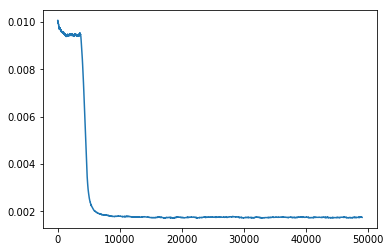

In [25]:
plt.plot(running_mean(loss_history, 1000))

## Результаты

### Подготовка отфильтрованных изображений на валидационной выборке

In [26]:
import scipy.stats as sps

def apply_gaussian_filter(source_image,
                          filtered_superpixels,
                          sigma=7,
                          k=5):
    image = source_image.copy()
    grid_x, grid_y = np.meshgrid(np.arange(-(k // 2), k // 2 + 1),
                                 np.arange(-(k // 2), k // 2 + 1))
    grid = np.array(list(zip(grid_x.ravel(), grid_y.ravel()))).reshape((k, k, 2))
    gaussian_window = sps.multivariate_normal(mean=[0, 0], cov=np.eye(2) * sigma).pdf(grid)
    gaussian_window /= gaussian_window.sum()
    for n in range(1024):
        i = (n // 32) * 7
        j = (n % 32) * 7
        image[i:i+7, j:j+7] = filtered_superpixels[n]
    for i in range(k // 2, source_image.shape[0] - k // 2):
        for j in range(k // 2, source_image.shape[1] - k // 2):
            image[i, j] = np.sum(image[i - k // 2:i + k // 2 + 1, j - k // 2:j + k // 2 + 1] \
                                 * gaussian_window)
    return image

In [27]:
SIGMA = 7
K = 5

def apply_gaussian_filter_parallel(data):
    image, superpixels = data
    return apply_gaussian_filter(image, superpixels, sigma=SIGMA, k=K)

In [28]:
depths_val_predicted = model.predict(rgbs_val, batch_size=32, verbose=1)

16541/16541 [==============================] - 55s 3ms/step


In [29]:
prediction_superpixels = np.array([extract_superpixels(image) for image in tqdm_notebook(depths_val_predicted)])
gt_superpixels = np.array([extract_superpixels(image) for image in tqdm_notebook(depths_val)])
prediction_features = np.array([extract_features(image) for image in tqdm_notebook(depths_val_predicted)])

In [32]:
BATCH_SIZE = 32

filtered_batches = []
for i in tqdm_notebook(range(0, len(depths_val), BATCH_SIZE)):
    superpixels_batch = prediction_superpixels[i:min(i + BATCH_SIZE, len(depths_val))]
    features_batch = prediction_features[i:min(i + BATCH_SIZE, len(depths_val))]
    filtered_batch = sess.run(z_filtered, feed_dict={feature_plh: features_batch,
                                                    z_plh: superpixels_batch[:, :, np.newaxis]}
                             )
    filtered_batches.append(filtered_batch)

In [33]:
filtered_superpixels = np.concatenate(filtered_batches, axis=0)
filtered_superpixels.shape

(16541, 1024, 1)

In [44]:
from multiprocessing import Pool
pool = Pool(160)
filtered_images = pool.map(apply_gaussian_filter_parallel,
                           zip(depths_val / 10, filtered_superpixels)
                          )

In [61]:
filtered_images = np.array(filtered_images)

In [62]:
filtered_images.shape

(16541, 224, 224)

### Сравнение качества на валидационной выборке

In [63]:
print("MSE of raw images:", np.mean((depths_val_predicted - depths_val) ** 2))
print("MSE of filtered images:", np.mean((filtered_images * 10 - depths_val) ** 2))

MSE of raw images: 0.3616211401499641
MSE of filtered images: 0.34023888637559724


In [65]:
print("log-MSE of raw images:", np.mean((np.log(depths_val_predicted + 1e-2) - np.log(depths_val + 1e-2)) ** 2))
print("log-MSE of filtered images:", 
      np.mean((np.log(filtered_images * 10 + 1e-2) - np.log(depths_val + 1e-2)) ** 2))

log-MSE of raw images: 0.08970439863487457
log-MSE of filtered images: 0.07114004677877604


### Визуализация

In [67]:
def unpreprocess(image):
    img_min = -123
    img_max = 151
    return (image - img_min) / (img_max - img_min)

In [66]:
rgbs_to_see = rgbs_val[::200]
predictions_to_see = depths_val_predicted[::200]
filtered_predictions_to_see = filtered_images[::200] * 10
gts_to_see = depths_val[::200]

In [68]:
print(rgbs_to_see.shape, gts_to_see.shape, predictions_to_see.shape, filtered_predictions_to_see.shape)

(83, 224, 224, 3) (83, 224, 224) (83, 224, 224) (83, 224, 224)


In [ ]:
n = len(predictions_to_see)
plt.figure(figsize=(16, n * 4))
for i in range(30):
    plt.subplot(n, 4, i * 4 + 1)
    plt.title('RGB', fontsize=12)
    plt.imshow(unpreprocess(rgbs_to_see[i]))
    
    plt.subplot(n, 4, i * 4 + 2)
    plt.title('Raw prediction', fontsize=12)
    plt.imshow(predictions_to_see[i] / 10., cmap='rainbow')
    
    plt.subplot(n, 4, i * 4 + 3)
    plt.title('Filtered prediction', fontsize=12)
    plt.imshow(filtered_predictions_to_see[i] / 10., cmap='rainbow')
    
    plt.subplot(n, 4, i * 4 + 4)
    plt.title('Ground truth', fontsize=12)
    plt.imshow(gts_to_see[i] / 10., cmap='rainbow')

In [ ]:
n = len(predictions_to_see)
plt.figure(figsize=(16, n * 4))
for i in range(30, n):
    plt.subplot(n, 4, i * 4 + 1)
    plt.title('RGB', fontsize=12)
    plt.imshow(unpreprocess(rgbs_to_see[i]))
    
    plt.subplot(n, 4, i * 4 + 2)
    plt.title('Raw prediction', fontsize=12)
    plt.imshow(predictions_to_see[i] / 10., cmap='rainbow')
    
    plt.subplot(n, 4, i * 4 + 3)
    plt.title('Filtered prediction', fontsize=12)
    plt.imshow(filtered_predictions_to_see[i] / 10., cmap='rainbow')
    
    plt.subplot(n, 4, i * 4 + 4)
    plt.title('Ground truth', fontsize=12)
    plt.imshow(gts_to_see[i] / 10., cmap='rainbow')